# **2. Exploratory Data Analysis**

In this notebook I'll load and analyzed the dataset available for training the final model, which is located at data/Training_Essay_Data.csv (root relative).

The analyzes will include:

* Checking out the target variable balancing;

* Checking out for invalid data inputs;

* checking the number of characters per text;

* Generating a worldcloud for detecting possible valuous insights;

* Checking for possibles anomalies.

## **About the Dataset**

The dataset used in this project was downloaded from Kaggle at this link: https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset

I dowloaded it and stored at data/ directory with it's the relative LICENSE file. So, that way the dataset can be easily loaded with the pandas library.

### **Variables Dictionary:**

1. **text**
    * Text generated by human or machine;

    * Unstructed data (requires preprocessing).

2. **generated**
    * Indicates if the text was generated by a machine or not;

    * Nominal data;
    
    * Possible values: 0 (not generated) or 1 (generated).

For more detail about the data, take a look at the link above.

## **Importing libraries**

In [1]:
import re

# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# text manipulation
import spacy
from spacy.tokens import Doc

from wordcloud import WordCloud

# text statistics
import textstat

### **Setting up libraries**

In [2]:
# set seaborn style
sns.set_style("darkgrid")

In [3]:
# setting up spacy and disabling unused pipeline components
nlp = spacy.load('en_core_web_md', disable=['ner', 'lemmatizer', 'textcat', 'custom'])

## **Loading dataset**

In [4]:
DATASET_PATH = '../data/Training_Essay_Data.csv'
df = pd.read_csv(DATASET_PATH)

## **Data Cleaning**

Before analysing the data, let's look for some irregularities in the dataset, like invalid data types or too small texts.

In [5]:
# show first dataset rows
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [6]:
# show last dataset rows
df.tail()

,text,generated
29140,There has been a fuss about the Elector Colleg...,0
29141,Limiting car usage has many advantages. Such a...,0
29142,There's a new trend that has been developing f...,0
29143,As we all know cars are a big part of our soci...,0
29144,Cars have been around since the 1800's and hav...,0


In [7]:
# show some text example
print(df.iloc[0].values[0])

Car-free cities have become a subject of increasing interest and debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, and limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted or completely banned, with a focus on alternative transportation methods and sustainable urban planning. This essay explores the benefits, challenges, and potential solutions associated with the idea of car-free cities.  Benefits of Car-Free Cities  Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution and greenhouse gas emissions. Fewer cars on the road mean cleaner air and a significant decrease in the contribution to global warming.  Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents and a safer urban environmen

In [8]:
# show dataset data informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


As we can see above, the dataset has 29145 entries and appears to not have any null value, and also the data type looks correct.

But, for precaution, let's see it there is no empty or invalid texts or invalid numbers for the variable `generated`.

In [9]:
# check invalid strings
if (~df.text.str.contains('\w')).sum() > 0: # \w check for word characters absence
    print('Invalid values encountered!')
    display(df[(~df.text.str.contains('\w'))])
else:
    print('No invalid values encountered.')

Invalid values encountered!


,text,generated
2743,],1


In [10]:
# check invalid values for ´generated´
if (~df.generated.isin([0, 1])).sum() > 0:
    print('Invalid values encountered!')
    display(df[~df.generated.isin([0, 1])])
else:
    print('No invalid values encountered.')

No invalid values encountered.


The `generated` variable is ok, but `text` has one "invalid" example.

The invalid example is "]". And think on it, it doesn't bring any valuos insight to predict the target variable. And how it's just a unique example I'll just discard it.

In [11]:
# drop the invalid index 2743 and create clean_df
df_clean = df.drop(2743)

Now let's calculate de length of each text.

In [12]:
# count text lengths
texts_lengths = []
for text in df_clean.text:
    texts_lengths.append(len(text))

# transform to a numpy array for better manipulation
texts_lengths = np.array(texts_lengths)

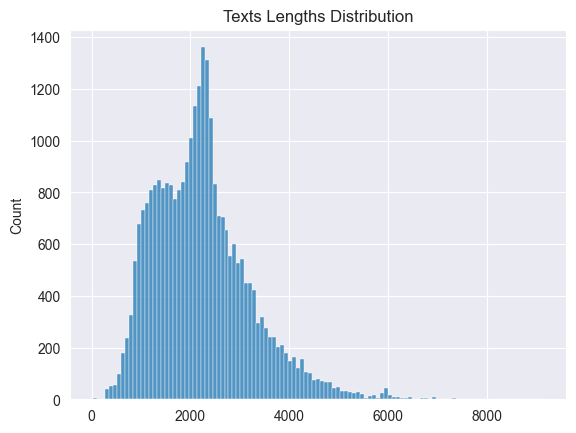

In [13]:
# show text lenghts distribution
sns.histplot(data=texts_lengths).set(title='Texts Lengths Distribution');

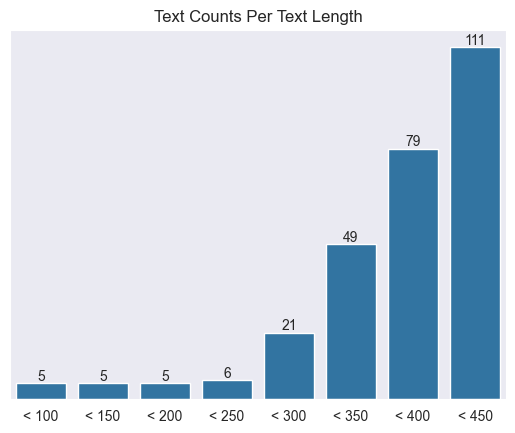

In [14]:
# texts count in the interval from 100 to 500 characyers (step = 50)
texts_lengths_intervals_count = { }
for i in range(100, 500, 50):
    texts_lengths_intervals_count[f'< {i}'] = (texts_lengths < i).sum()

# show results
ax = sns.barplot(data=texts_lengths_intervals_count)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_yticks([])
ax.set_title('Text Counts Per Text Length')

plt.show()

Small texts maybe not have too many information to predict if a text is generated by an human or AI. Dued to that, I decided to dicard texts with less than 300 characters, wich will result in the removing of 21 texts from the dataset. Also, this requirement will be present in the final product, that way, I can remove from all the data (train and test) because it will not bad effect test data.

In [15]:
# removing texts with less than 300 characters
df_clean = df_clean[texts_lengths >= 300]

In [16]:
# show df_clean shape
df_clean.shape

(29123, 2)

### **Splitting the data**

Before proceed, we must have some caution to avoid data leak. So I'll split the data into train and test set.

The criterias to do it will be:

* 80% of the data will be used to train the ML model;

* The division must mantain the target variable balancing.

In [17]:
df_train, df_test = train_test_split(df_clean, random_state=42, train_size=0.8, stratify=df_clean.generated)

# show train and test sizes
print(f'Training examples: {df_train.shape[0]}')
print(f'    Target balancing {(df_train.generated == 1).sum() / df_train.shape[0] * 100:.2f}%')

print(f'\nTesting examples: {df_test.shape[0]}')
print(f'    Target balancing {(df_test.generated == 1).sum() / df_test.shape[0] * 100:.2f}%')

Training examples: 23298
    Target balancing 39.89%

Testing examples: 5825
    Target balancing 39.90%


With this, we also answer to one of our questions: target variable balancing. 

As we can see, our dataset has a **good balancing with almost 40% of the texts examples generated by AI**.

## **Building a WordCloud**

In this section I'll create a WordCloud for human and machine genrated texts. May this give me some valuable insight.

In [18]:
# separating text generated by humans and machines
human_text = df_train.text[df_train.generated == 0]
ai_text = df_train.text[df_train.generated == 1]

In [19]:
# tranform texts into spacy docs
human_docs = [doc for doc in nlp.pipe(human_text, n_process=2)]
ai_docs = [doc for doc in nlp.pipe(ai_text, n_process=2)]

In [20]:
def remove_stopwords(doc: Doc) -> Doc:
    '''
    Helper function to remove stopwords from the given spacy doc.

    Parameters
    ---
    - doc: spacy doc.

    Returns
    ---
    - a spacy doc without stopwords.
    '''

    words = []
    spaces = []
    pos = []
    for token in doc:
        if not token.is_stop:
            words.append(token.text)
            spaces.append(token.whitespace_)
            pos.append(token.pos_)

    return Doc(vocab=nlp.vocab, words=words, spaces=spaces, pos=pos)

def remove_irrelevant_info(doc: Doc) -> Doc:
    '''
    Helper funtion to remove irrelevant information from the given spacy doc.
    Irrelevant info can be anything that has no letter.

    Parameters
    ---
    - doc: spacy doc.

    Returns
    ---
    - a spacy doc with irrelevant informantion removed.
    '''

    words = []
    spaces = []
    pos = []
    for token in doc:
        if re.match('[a-zA-Z]', token.text):
            words.append(token.text)
            spaces.append(token.whitespace_)
            pos.append(token.pos_)

    return Doc(vocab=nlp.vocab, words=words, spaces=spaces, pos=pos)

In [21]:
# clean text tokens
clean_human_docs = []
for doc in human_docs:
    clean_doc = remove_stopwords(doc)
    clean_doc = remove_irrelevant_info(clean_doc)
    clean_human_docs.append(clean_doc)

clean_ai_docs = []
for doc in ai_docs:
    clean_doc = remove_stopwords(doc)
    clean_doc = remove_irrelevant_info(clean_doc)
    clean_ai_docs.append(clean_doc)

In [22]:
def display_word_cloud(docs):
    '''
    Helper function to display a WordCloud from the given spacy docs.

    Parameters
    ---
    - list of spacy docs
    '''

    # create word cloud
    word_cloud = WordCloud(
        background_color='black',
        width=1600, height=800
    ).generate(' '.join([doc.text for doc in docs]))

    # plot word cloud
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.show()

### **Human Text WordCloud**

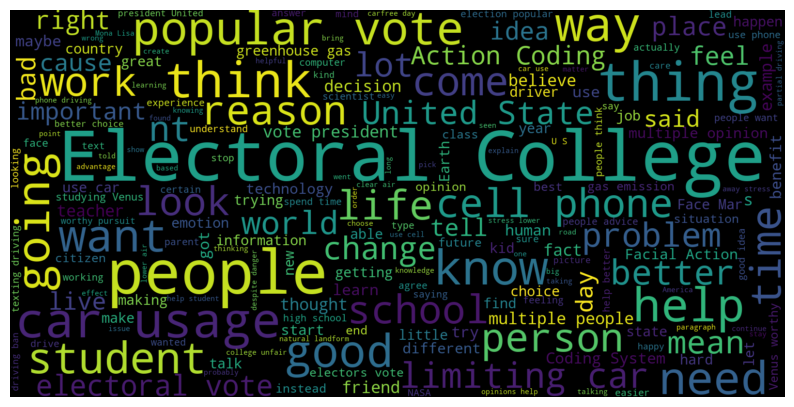

In [23]:
display_word_cloud(clean_human_docs)

### **AI Text WordCloud**

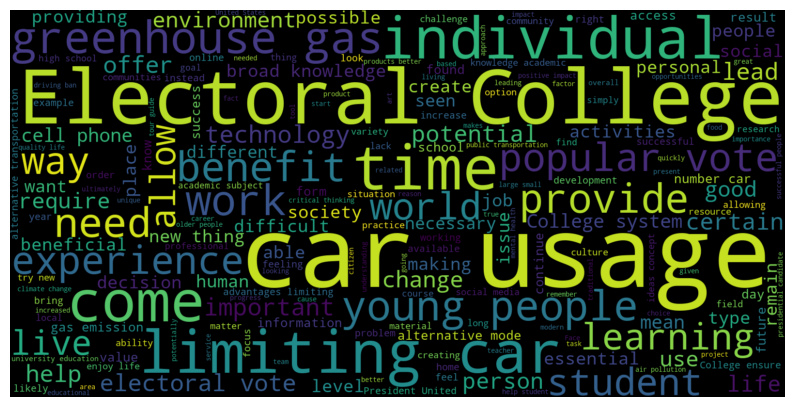

In [24]:
display_word_cloud(clean_ai_docs)

Looking at the wordclouds above, we can just infer the context of all the texts (which seems to be very similar in both cases).
So, how I'm not interested in the specific content, I'll remove the nouns to look for some more valuable insight.

### **Removing Nouns**

In [25]:
def remove_nouns(doc: Doc) -> Doc:
    '''
    Helper function to remove nouns from the given spacy doc.

    Parameters
    ---
    - doc: spacy doc.

    Returns
    ---
    - a spacy doc with nouns removed.
    '''

    words = []
    spaces = []
    pos = []
    for token in doc:
        if token.pos_ not in ['NOUN', 'PROPN']:
            words.append(token.text)
            spaces.append(token.whitespace_)
            pos.append(token.pos_)
            

    return Doc(vocab=nlp.vocab, words=words, spaces=spaces, pos=pos)

In [26]:
# remove nouns
no_noun_human_docs = [remove_nouns(doc) for doc in clean_human_docs]
no_noun_ai_docs = [remove_nouns(doc) for doc in clean_ai_docs]

### **No Noun Human Text WordCloud**

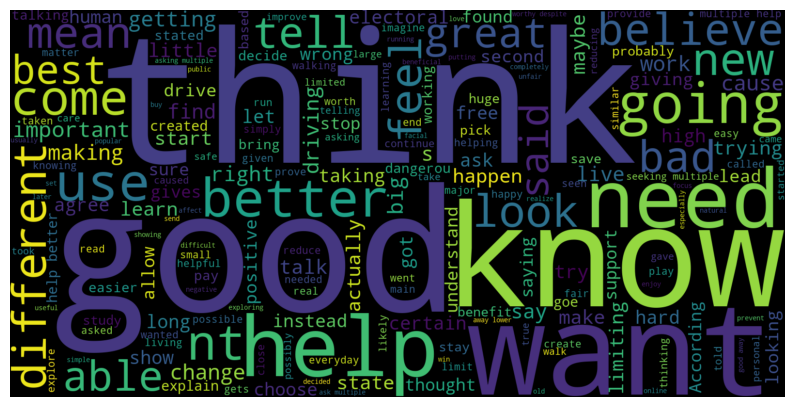

In [27]:
display_word_cloud(no_noun_human_docs)

### **No Noun AI Text WordCloud**

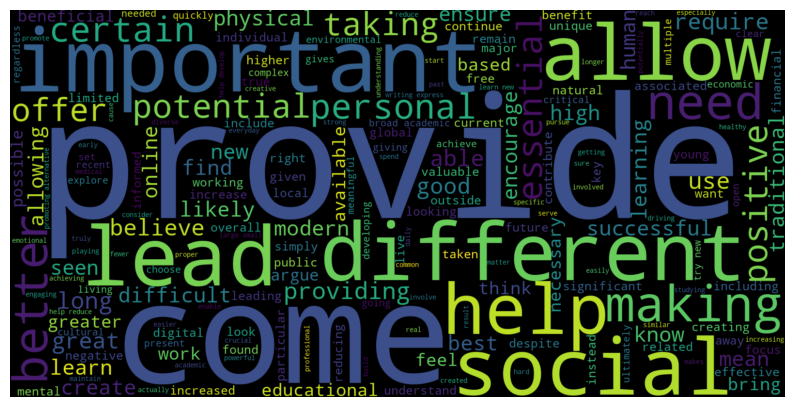

In [28]:
display_word_cloud(no_noun_ai_docs)

#### **Insights**

* Removing the nouns makes it possible to be less dependent on the content present in our available data to train. This means the final model may work better on other texts with completely different contexts if we ignore the nouns (this way we can focus on non-substantive linguistic elements).

## **Analyzing Lexical Diversity**

Another valuable insight might be the lexical diversity of the docs. Let's measure it.

Note: I'll use the not cleaned data to calculate the lexical diversity based on the entire text.

In [37]:
def calculate_lexical_diversity(doc: Doc) -> float:
    '''
    Helper function to calculate the lexical diversity of the given spacy doc.

    Parameters
    ---
    - doc: spacy doc.

    Returns
    ---
    - ratio of unique words to total words.
    '''
    
    # get unique words
    unique_words = set(token.text.lower() for token in doc)

    # calculate lexical diversity
    total_words = len(doc)
    unique_words_count = len(unique_words)
    lexical_diversity = unique_words_count / total_words

    return lexical_diversity

In [38]:
# calculate lexical diversity for each doc
human_lexical_diversity = []
for doc in human_docs:
    lexical_diversity = calculate_lexical_diversity(doc)
    human_lexical_diversity.append(lexical_diversity)

ai_lexical_diversity = []
for doc in ai_docs:
    lexical_diversity = calculate_lexical_diversity(doc)
    ai_lexical_diversity.append(lexical_diversity)

In [39]:
# show mean
print('Human lexical diversity mean:', round(np.mean(human_lexical_diversity), 2), '+-', round(np.std(human_lexical_diversity), 2))
print('AI lexical diversity mean:', round(np.mean(ai_lexical_diversity), 2), '+-', round(np.std(ai_lexical_diversity), 2))

Human lexical diversity mean: 0.41 +- 0.08
AI lexical diversity mean: 0.51 +- 0.13


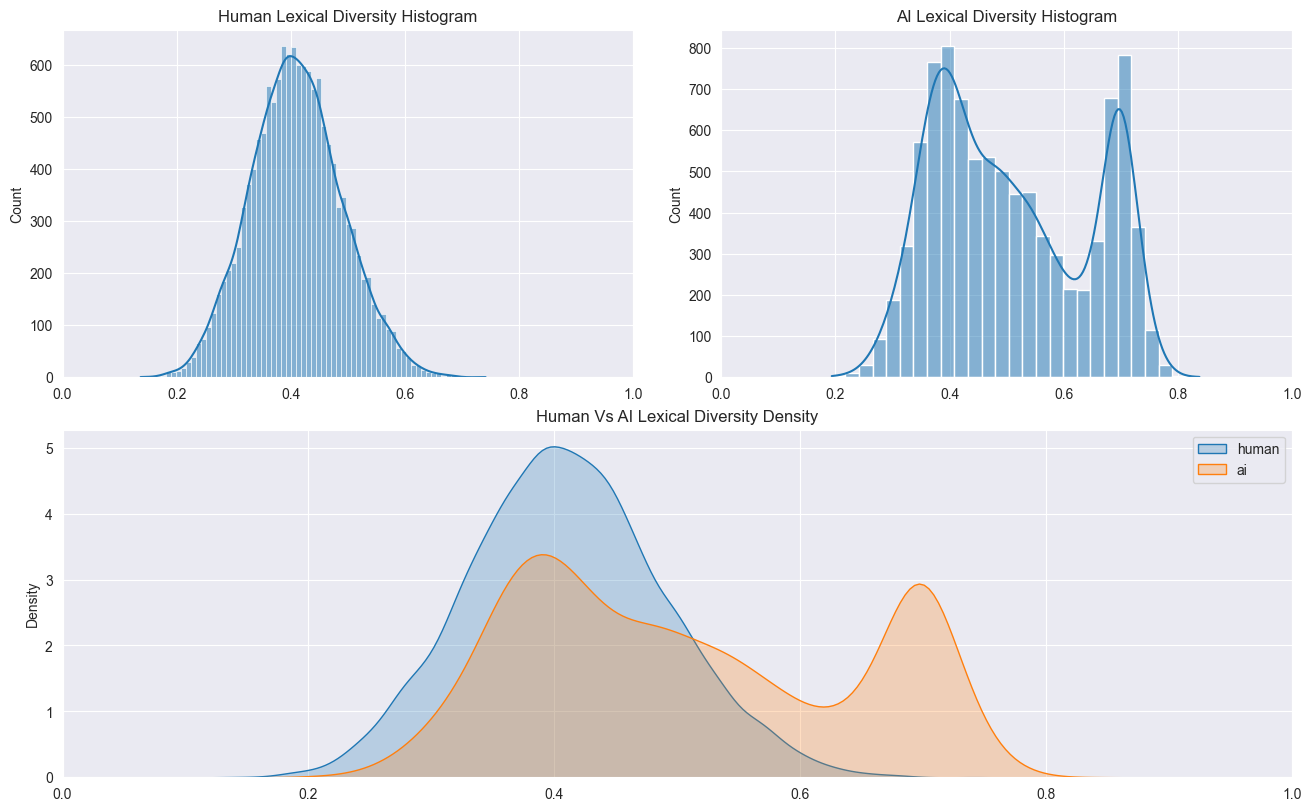

In [40]:
# show lexical diversity distributions side by side
fig = plt.figure(layout='constrained', figsize=(13, 8))

# config plot layout
gs = plt.GridSpec(nrows=2, ncols=2, figure=fig)
ax0= fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1:])
ax2 = fig.add_subplot(gs[1, :])

# plot histogram
sns.histplot(data=human_lexical_diversity, kde=True, ax=ax0)
sns.histplot(data=ai_lexical_diversity, kde=True, ax=ax1)

# plot density
sns.kdeplot(data=human_lexical_diversity, label='human', fill=True, ax=ax2)
sns.kdeplot(data=ai_lexical_diversity, label='ai', fill=True, ax=ax2)

# config plot
ax0.set_title('Human Lexical Diversity Histogram')
ax0.set_xlim(0, 1)

ax1.set_title('AI Lexical Diversity Histogram')
ax1.set_xlim(0, 1)

ax2.set_title('Human Vs AI Lexical Diversity Density')
ax2.set_xlim(0, 1)
ax2.legend()

plt.show()

### **Insights**

* **Human lexical diversity** seems to follow a normal distribution with **mean = 0.41 and std = 0.08**;

* **AI lexical diversity** don't follow a normal distribution. It has **mean = 0.51 and std = 0.13**;

* AI lexical diversity distribution has two observable ridges: one is more similar to the Human distribution; other is more to the right (more diversity);

* We can infer from this that some AIs texts are more similar to human written but there are some AIs texts that go beyond the curve.


## **Analyzing Reading Ease**

Writing can be hard task when you think about reading ease. So that's possibly a valuable insight to averigaute from human and ai texts. For this task I'll be using textstat library that provie us some statistics about texts, and one of them is exactly reading ease score.

In [41]:
def calcualte_reading_ease_score(doc: Doc) -> float:
    '''
    Helper function to calculate reading ease score from the given spacy doc.

    Parameters
    ---
    - doc: spacy doc.

    Returns
    ---
    - reading ease score.
    '''
    
    try:
        # calculate score
        return textstat.flesch_reading_ease(doc.text)
    except ZeroDivisionError:
        return 0

In [42]:
# calculate reading ease score for each doc
human_reading_ease_scores = []
for doc in human_docs:
    reading_ease_scores = calcualte_reading_ease_score(doc)
    human_reading_ease_scores.append(reading_ease_scores)

ai_reading_ease_scores = []
for doc in ai_docs:
    reading_ease_scores = calcualte_reading_ease_score(doc)
    ai_reading_ease_scores.append(reading_ease_scores)

In [43]:
# show mean
print('Human reading ease score mean:', round(np.mean(human_reading_ease_scores), 2), '+-', round(np.std(human_reading_ease_scores), 2))
print('AI reading ease score mean:', round(np.mean(ai_reading_ease_scores), 2), '+-', round(np.std(ai_reading_ease_scores), 2))

Human reading ease score mean: 67.83 +- 16.81
AI reading ease score mean: 46.26 +- 16.07


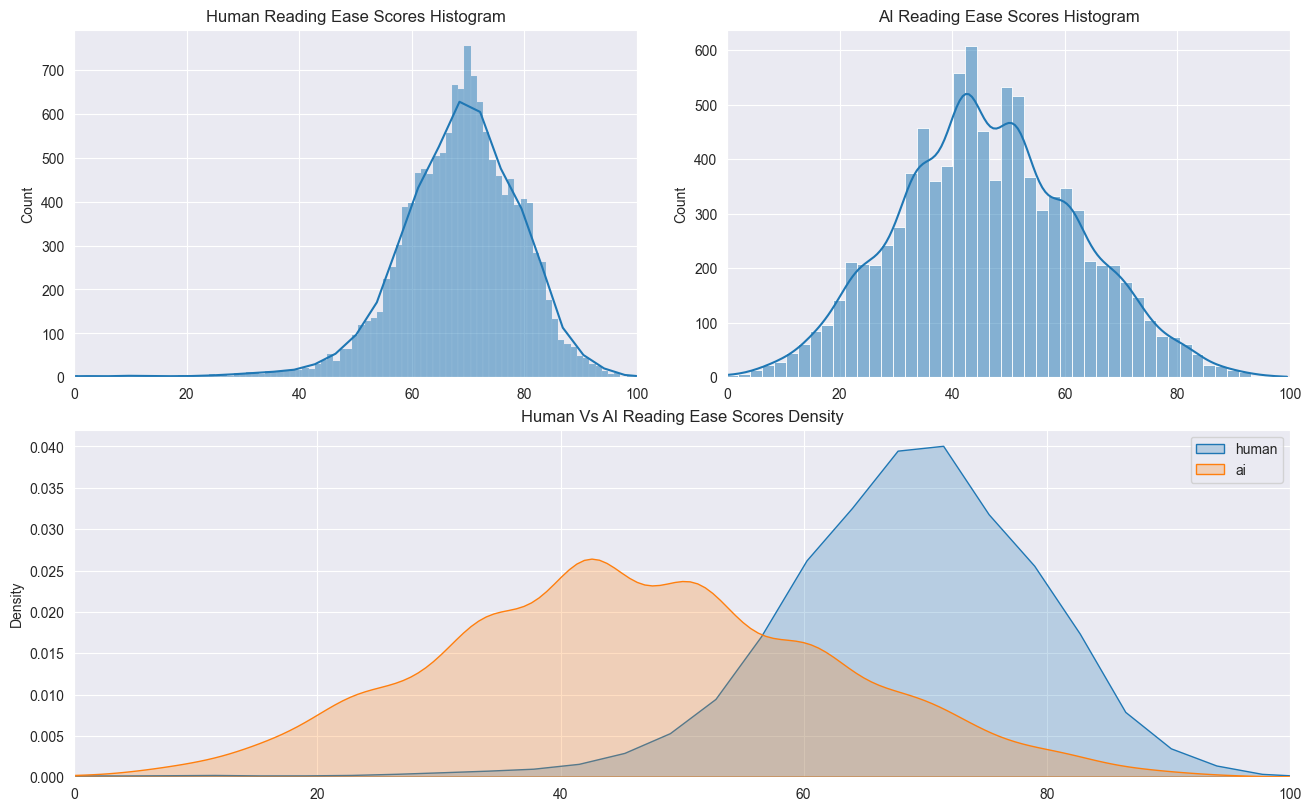

In [44]:
# show reading ease score distributions side by side
fig = plt.figure(layout='constrained', figsize=(13, 8))

# config plot layout
gs = plt.GridSpec(nrows=2, ncols=2, figure=fig)
ax0= fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1:])
ax2 = fig.add_subplot(gs[1, :])

# plot histogram
sns.histplot(data=human_reading_ease_scores, kde=True, ax=ax0)
sns.histplot(data=ai_reading_ease_scores, kde=True, ax=ax1)

# plot density
sns.kdeplot(data=human_reading_ease_scores, label='human', fill=True, ax=ax2)
sns.kdeplot(data=ai_reading_ease_scores, label='ai', fill=True, ax=ax2)

# config plot
ax0.set_title('Human Reading Ease Scores Histogram')
ax0.set_xlim(0, 100)

ax1.set_title('AI Reading Ease Scores Histogram')
ax1.set_xlim(0, 100)

ax2.set_title('Human Vs AI Reading Ease Scores Density')
ax2.set_xlim(0, 100)
ax2.legend()

plt.show()

### **Insights**

* **Human reading ease scores** seems to follow a normal distribution with **mean = 67.83 and std = 16.81**;

* **AI reading ease scores** seems to follow a normal distribution with **mean = 46.26 and std = 16.07**;

* Human reading ease scores are greater than AI scores in general.

## **Conclusion**

The main insights we found are:

* Dataset had a good balancing;

* Removing nouns make us less dependent on the dataset content;

* Some AIs had better lexical diversity;

* Human reading ease scores are greater than AI scores.